In [1]:
import cv2 as cv
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns
from scipy import stats
import os
import re
import pickle
import imutils
from scipy.signal import find_peaks, savgol_filter
from pathlib import Path
import glob
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from utils import init_condition, select_roi_interactive, load_significant_frames
from utils import noise_detection,  cfar_fast
from utils import find_periods
from utils import get_behavior_timestamps, get_tail_angles, low_pass_filt, load_data, load_annotation

# Input data

In [2]:
fish_date = "20241022"
no = "F1"
set_no = 4

main_dir = f"F://2p_hsc//{fish_date}//hsa-sizetuning//{no}//"
excel_path = f"F://annotation//{fish_date}-{no}.xlsx"

avis = glob.glob(f"{main_dir}/**.mp4")
avis = [str(Path(avi).resolve()) for avi in avis]
avis

['F:\\2p_hsc\\20241022\\hsa-sizetuning\\F1\\F1-set001-b-sweep-200-fps.mp4',
 'F:\\2p_hsc\\20241022\\hsa-sizetuning\\F1\\F1-set002-r-spiral-200-fps.mp4',
 'F:\\2p_hsc\\20241022\\hsa-sizetuning\\F1\\F1-set003-l-spiral-200-fps.mp4',
 'F:\\2p_hsc\\20241022\\hsa-sizetuning\\F1\\F1-set004-b-spiral-200-fps.mp4']

In [3]:
avi = avis[set_no - 1]
fish_id = fish_date + '-' + no
h5_path = avi.split('.')[0] + ".h5"

save_dir = f"F:/swim_motion_data/size_tunning_v2/{fish_id}/set00{set_no}"
Path(save_dir).mkdir(parents=True, exist_ok = True)

In [4]:
if Path(f"{save_dir}/cord.txt").exists():
   with open(f"{save_dir}/cord.txt", "r") as f:
       x_cord = int(f.readline().split()[-1])
       y_cord = int(f.readline().split()[-1])
else:
    import winsound
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    x_cord, y_cord = select_roi_interactive(avi)
    with open(f"{save_dir}/cord.txt", "w") as f:
        f.write("x\t" + str(x_cord))
        f.write("\ny\t" + str(y_cord))
capture, num_frames, hsv = init_condition(avi, x_cord, y_cord)

## preview the cropped video

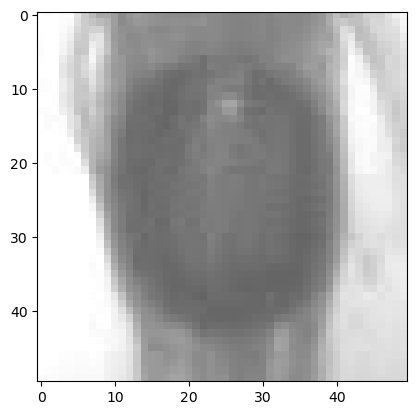

In [5]:
capture.set(cv.CAP_PROP_POS_FRAMES, 1)

# Read and crop the first frame again
ret, frame = capture.read()
if ret:
    cropped_frame = frame[y_cord:y_cord+50, x_cord:x_cord+50]
    plt.imshow(cropped_frame)

# Step 1: calcuate mean squared erro(mseval) and fit bimodel

100%|███████████████████████████████████████████████████████████████████████▉| 155997/155999 [01:12<00:00, 2155.20it/s]


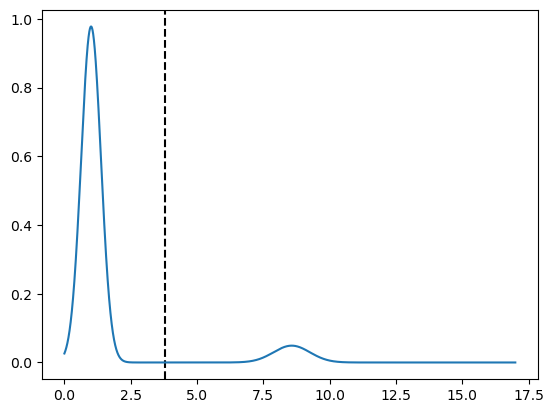

In [6]:
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

mseval = np.zeros(num_frames - 1) 
ret, prev_frame = capture.read()
prev_frame = prev_frame[y_cord:y_cord+50, x_cord:x_cord+50]
prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

for i in tqdm(range(1, num_frames)):
    ret, curr_frame = capture.read()
    if not ret:
        break
        
    curr_frame = curr_frame[y_cord:y_cord+50, x_cord:x_cord+50]
    curr_gray = cv.cvtColor(curr_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

    diff = curr_gray - prev_gray
    mse = np.mean(diff ** 2)
    mseval[i-1] = mse 
    
    prev_gray = curr_gray.copy()

################ fitting
gmm = GaussianMixture(n_components = 2)
mseval = np.array(mseval)
gmm.fit(mseval.reshape(-1, 1))

x = np.linspace(0, np.ceil(np.max(mseval)), 10000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

#### peak
peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# Get the values between the two peaks and find the minimum
valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
minimum = x[valid_indices[np.argmin(y[valid_indices])]]

plt.axvline(minimum, color='black', linestyle='--', 
            label='Inflection')
plt.plot(x, y)

In [7]:
mse_threshold = minimum
res = [] ######## list for significant motion
for a in range(len(mseval)):
        if mseval[a] > mse_threshold:
            res.append(a)
frames = load_significant_frames(avi, res, x_cord, y_cord)

100%|████████████████████████████████████████████████████████████████████████| 156000/156000 [01:39<00:00, 1573.37it/s]


# Step 2: Optical Flow

Analyzing Motion: 100%|████████████████████████████████████████████████████████| 13113/13113 [00:06<00:00, 1907.53it/s]


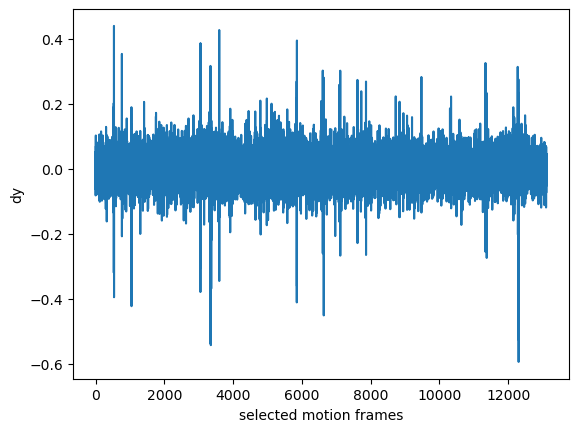

In [8]:
if Path(f"{save_dir}/y_shift.npy").exists():
    vertical_motion = np.load(f"{save_dir}/y_shift.npy")
else:
    vertical_motion = []
    prev_gray = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)
    
    for frame in tqdm(frames[1:], desc="Analyzing Motion"):
        curr_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Calculate dense optical flow
        flow = cv.calcOpticalFlowFarneback(
            prev_gray, curr_gray, 
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )
        
        # Focus on vertical motion (y-axis component)
        vertical_flow = flow[..., 1]
        avg_vertical = np.mean(vertical_flow)
        vertical_motion.append(avg_vertical)
        
        prev_gray = curr_gray
    vertical_motion = -np.array(vertical_motion) ###### make positive to upward motion 
    np.save(f"{save_dir}/y_shift.npy",vertical_motion)

plt.plot(vertical_motion)
plt.ylabel("dy")
plt.xlabel("selected motion frames")

######################## save result if wanted 
np.save(f"{save_dir}/y_shift.npy",vertical_motion)

# Step 3: Find episode

In [9]:
noise_level = noise_detection(
    vertical_motion,
    noise_window=20,       # Larger for stable baselines
    min_duration=1,        # Minimum frames for valid peak
    prominence_factor=5  # Higher = fewer false positives
)

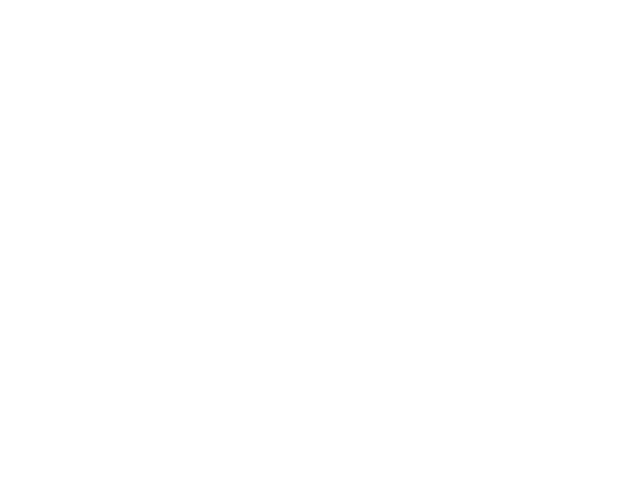

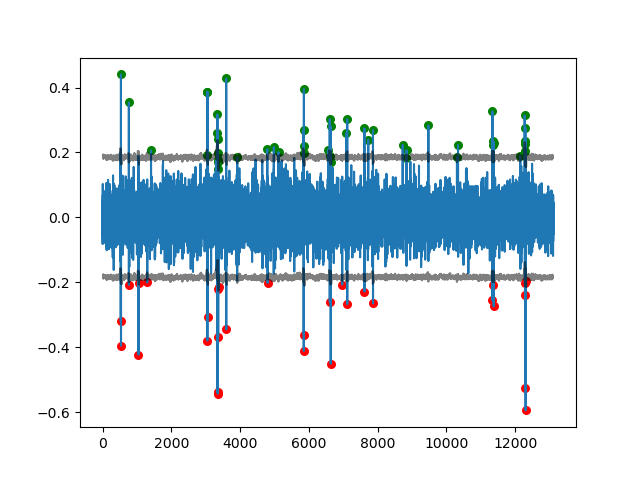

In [10]:
%matplotlib widget

# 4.1
factor = 4
up_threshold, down_threshold = cfar_fast(vertical_motion, num_guard_cells=1, num_ref_cells=15, bias=noise_level * factor)
up_peak_idxs = []
down_peak_idxs = []
for i, dy in enumerate(vertical_motion):
    if dy > up_threshold[i]:
        up_peak_idxs.append(i)
    if dy < down_threshold[i]:
        down_peak_idxs.append(i)
        
fig = plt.figure()
fig, ax = plt.subplots(1)
ax.plot(vertical_motion)
ax.plot(up_threshold, c="black", alpha=0.5)
ax.plot(down_threshold, c="black", alpha=0.5)
# Plot peaks
ax.scatter(up_peak_idxs, vertical_motion[up_peak_idxs], c='green', s=30, label='Valid Up')
ax.scatter(down_peak_idxs, vertical_motion[down_peak_idxs], c='red', s=30, label='Valid Down')

## Generate dataframe for saving

In [11]:
y_motions = np.zeros(num_frames)

ori_up_idxs = []
ori_down_idxs = []
for i, re in enumerate(res[:-1]):
    y_motions[re] = vertical_motion[i]
for i in up_peak_idxs:
    ori_up_idxs.append(res[i])
for j in down_peak_idxs:
    ori_down_idxs.append(res[j])

df_up = pd.DataFrame(
    {
        "res": up_peak_idxs,
        "ori": ori_up_idxs
    }
)
df_down = pd.DataFrame(
    {
        "res": down_peak_idxs,
        "ori": ori_down_idxs
    }
)

df_up["ysft"] = y_motions[df_up["ori"].values]
df_down["ysft"] = y_motions[df_down["ori"].values]

df_up["is_up"] = [1] * len(df_up)
df_down["is_up"] = [-1] * len(df_down)
combined_df = pd.concat([df_up, df_down], ignore_index=True)
combined_df.to_csv(f'{save_dir}/y_shift_idx.csv', index=False)

episodes = find_periods(ori_up_idxs, ori_down_idxs)
np.save(f"{save_dir}/episodes_idx.npy", episodes)

# Step 4: Generate clips anad plots for validations

## clips

In [12]:
%%capture
if Path(f'{save_dir}/clips/').exists():
    import shutil
    shutil.rmtree(f'{save_dir}/clips/')

import cv2
video_path = avi
output_folder = f'{save_dir}/clips/'
Path(output_folder).mkdir(parents=True, exist_ok = True)

fps = 200
frame_adjustment = int(fps * 1)  # 1 second worth of frames

# Open the video
cap = cv2.VideoCapture(video_path)

# Get video properties
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Function to add text to a frame
def add_text_to_frame(frame, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  # White color
    font_thickness = 2
    cv2.putText(frame, text, (50, 50), font, font_scale, font_color, font_thickness)
    return frame

# Iterate through the frame ranges
for i, (start_frame, end_frame) in enumerate(episodes):
    # Adjust start and end frames
    adjusted_start = max(0, start_frame - frame_adjustment)
    adjusted_end = min(total_frames - 1, end_frame + frame_adjustment)

    # Set the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, adjusted_start)

    # Define the output video writer
    output_path = f'{output_folder}clip_{i+1}_{int(start_frame/fps)}-{int(end_frame/fps)}.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps * 0.2, (width, height))

    # Loop through the frames in the range
    for frame_num in range(adjusted_start, adjusted_end + 1):
        ret, frame = cap.read()
        if not ret:
            break

        # Add "episode" text to the frame
        if frame_num in list(range(start_frame, end_frame)):
            frame = add_text_to_frame(frame, "episode")

        # Write the frame to the output video
        out.write(frame)

    # Release the output video writer
    out.release()
    print(f"clips {i+1} is ready")

# Release the video capture object
cap.release()

print("Clips have been successfully created.")

## plots

In [13]:
fs = 200  # target sampling frequency
t, eye_angles, tail_angles = load_data(h5_path, fs)
eye_angles_filt = low_pass_filt(eye_angles, fs, 2)
bout_params = {
    "n_angles_avg": 5,  # number of angles to average for tail tip angle
    "sigma": 4,  # sigma for gaussian filter
    "high": 10,  # high threshold for tail vigor
    "low": 5,  # low threshold for tail vigor
}
mean_tip_angle = tail_angles[..., -bout_params["n_angles_avg"] :].mean(-1)

In [14]:
is_pc, pc_only, strike_only, df_trial= load_annotation(excel_path, set_no)
df_trial["t_start"] = df_trial["t_start"]*200
df_trial["t_end"] = df_trial["t_end"]*200

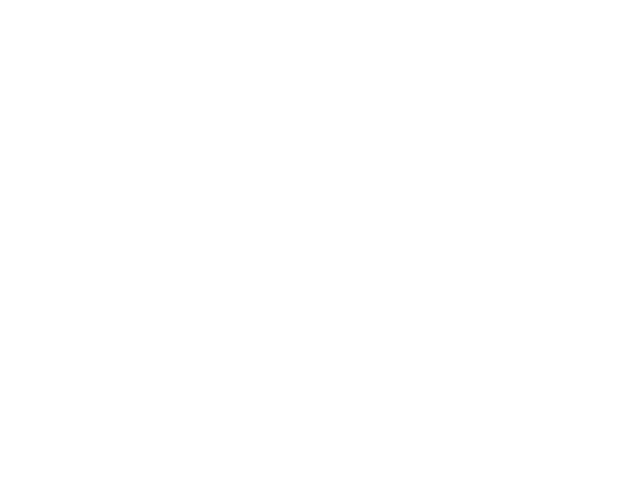

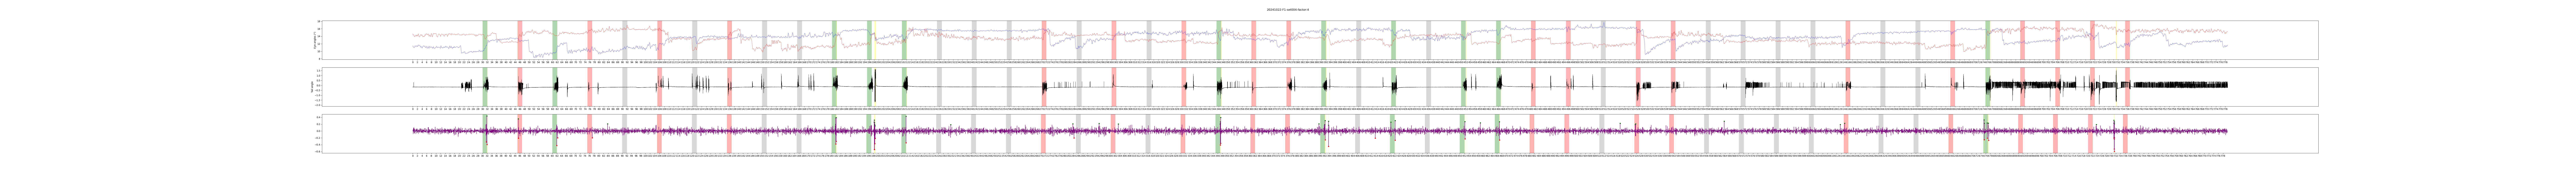

In [15]:
seconds = np.arange(0, 780,2)
tick_locations = np.arange(0, 780,2)*200

fig = plt.figure()
fig, axes = plt.subplots(3,1, figsize=(150,10)) # 100 8

ax1 = axes[0]
ax1.set_ylabel("Eye angles (°)")
ax1.plot(eye_angles_filt[:, 0], color="b", lw=0.5)
ax1.plot(eye_angles_filt[:, 1], color="r", lw=0.5)
# Set ticks and labels
ax1.set_xticks(tick_locations)
ax1.set_xticklabels([f"{s}" for s in seconds])


ax2 = axes[1]
ax2.set_ylabel("Tail angle")
ax2.plot(mean_tip_angle, color="black", lw=0.5)
# Set ticks and labels
ax2.set_xticks(tick_locations)
ax2.set_xticklabels([f"{s}" for s in seconds])

ax3 = axes[2]
ax3.plot(np.zeros(len(y_motions)))
ax3.stem(np.arange(len(y_motions)), y_motions, linefmt='purple', markerfmt=' ', basefmt=' ')
ax3.scatter(ori_up_idxs, y_motions[ori_up_idxs], c='green', s=15, label='Valid Up')
ax3.scatter(ori_down_idxs, y_motions[ori_down_idxs], c='red', s=15, label='Valid Down')
# Set ticks and labels
ax3.set_xticks(tick_locations)
ax3.set_xticklabels([f"{s}" for s in seconds])


for ax in axes:
    for j in range(len(df_trial)):
        if is_pc[j] == 0:
            ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='grey', alpha=0.3, lw=0.5, zorder=-100)
        elif pc_only[j] == 1:
            ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='red', alpha=0.3, lw=0, zorder=-100)
        if strike_only[j] == 1:
            ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='green', alpha=0.3, lw=0, zorder=-100)

for ax in axes:
    for episode in episodes:
        ax.axvspan(episode[0], episode[-1], color='yellow', alpha=0.3, lw=0.5, zorder=-100)
   


title = f"{fish_id}-set00{set_no}-factor:{factor}"
plt.suptitle(title, y=0.95)

plt.savefig(f"{save_dir}/full_plot.png", transparent=None,
        facecolor='white', dpi = 500
       )